## Bike Sharing Demand Prediction

We used the dataset from [Kaggle](https://www.kaggle.com/c/bike-sharing-demand/overview) to develop a machine learning model to predict a bike sharing demand. 

In [43]:
# Import important modules

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

sns.set_style('darkgrid')

In [44]:
# Load training dataset
train = pd.read_csv('train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [45]:
# Explore columns - it has 12 columns
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [46]:
# Description
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [47]:
# The given train dataset has 10886 rows and 12 columns. Season, holiday, workingday and weather columns are 
# categorical. Rest all, except ‘datetime’ are numerical columns. We engineer two more features,‘time’ and ‘month’, 
# using ‘datetime’ column. And then drop unnecessary column(s) (See 'pre_processing' function below for more detail).
print(train.shape)

(10886, 12)


In [48]:
# Load test data
test = pd.read_csv('test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [49]:
# Explore columns - it has 9 columns
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [50]:
# Description
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [51]:
# The given test dataset has 6493 rows and 9 columns
test.shape

(6493, 9)

In [52]:
def pre_processing(df):
    
        
    # Pre-processing train data
    #  Adding time and month to the dataframe using datatime column
    time=[]
    month=[]
    for i in df['datetime']:
            dt_object2 = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
            time.append(dt_object2.hour)
            month.append(dt_object2.month)
    df['time'] = pd.DataFrame(time)
    df['time'] = df['time'].astype(float)
    df['month'] = pd.DataFrame(month)
    df['month'] = df['month'].astype(float)

    # Dropping datetime column
    df.drop('datetime',axis=1, inplace=True) 


    # One hot encoding on categorical columns. pd.get_dummies converts categorical variable into dummy/indicator 
    # variables. More details about one-hot encoding is given in [3]. # drop_first=True for Dummy Variable Encoding.
    # df = pd.get_dummies(df,columns=['season','weather'], drop_first=True)  
    df = pd.get_dummies(df,columns=['season','weather', 'holiday', 'workingday'])


    # Median imputation if any
    for i in df.columns:
        df[i].fillna(value = df[i].median(), inplace=True) # Fill NA/NaN values using the specified method, here using median().
    
    return df

In [53]:
def model(df):
    
    global model


    # Adjust samples and labels to predict count
    y = df['count']  # df['count'] == df.count
    x = df.drop(['casual','registered','count'], axis = 1)  # drop 'casual' and 'registered' columns in addition 
    # to 'count' column (label) since they are similar to count.
    
    # Split the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30 ,random_state = 2)
     

    # Finding best parameters for RandomForestRegressor on X_train and y_train.
    rf = RandomForestRegressor(random_state=0)
    rf_params = {'n_estimators':np.arange(25,150,25),
                 'max_depth':np.arange(1,11,2),
                 'min_samples_leaf':np.arange(2,15,3)}
   
    gs_rf = GridSearchCV(rf,rf_params,cv=3)
    gs_rf.fit(x_train, y_train)
    
    best_params = gs_rf.best_params_
    
    # Fitting the model with best params on the whole data (x & y)
    RF = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                               max_depth=best_params['max_depth'],
                               min_samples_leaf=best_params['min_samples_leaf'],
                               random_state=0)
    
    model = RF.fit(x,y)  # Fit on whole data!
    count_pred = model.predict(x) # Make prediction on training data
    
    # Compute Error
    msle = mean_squared_log_error(count_pred, y)
    rmsle = np.sqrt(msle)
    print('RMLSE:', rmsle) 
    
    mae = mean_absolute_error(count_pred, y)
    rmae = np.sqrt(mae)
    print('RMAE:', rmae) 
    
    # Plotting important features
    importances = RF.feature_importances_
    plt.figure(figsize=(15, 10))
    plt.title('Count Feature Importance')
    plt.barh(range(len(importances)), importances, color='g', align='center')
    plt.yticks(range(len(importances)), x.columns)
    plt.xlabel('Relative Importance')
    plt.show()

In [54]:
# After pre-processing, the training dataset looks like
train_p = pre_processing(train)
train_p.head()

,temp,atemp,humidity,windspeed,casual,registered,count,time,month,season_1,...,season_3,season_4,weather_1,weather_2,weather_3,weather_4,holiday_0,holiday_1,workingday_0,workingday_1
0,9.84,14.395,81,0.0,3,13,16,0.0,1.0,1,...,0,0,1,0,0,0,1,0,1,0
1,9.02,13.635,80,0.0,8,32,40,1.0,1.0,1,...,0,0,1,0,0,0,1,0,1,0
2,9.02,13.635,80,0.0,5,27,32,2.0,1.0,1,...,0,0,1,0,0,0,1,0,1,0
3,9.84,14.395,75,0.0,3,10,13,3.0,1.0,1,...,0,0,1,0,0,0,1,0,1,0
4,9.84,14.395,75,0.0,0,1,1,4.0,1.0,1,...,0,0,1,0,0,0,1,0,1,0


In [55]:
# After pre-processing, the training dataset has 21 columns, however, 3 columns will be dropped in the model() 
train_p.shape

(10886, 21)

RMLSE: 0.3917830842592559
RMAE: 6.760605930215257


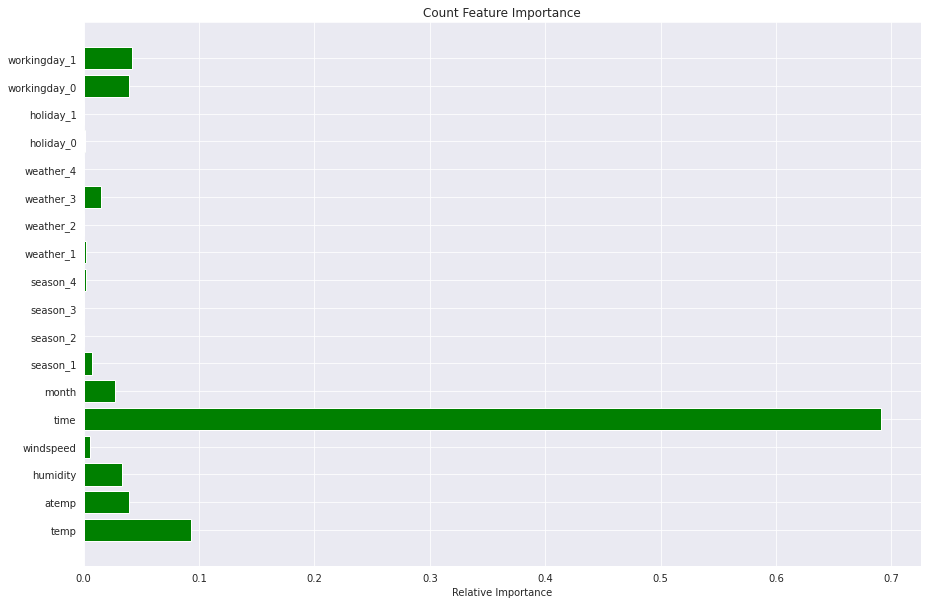

In [56]:
# Train the model
model(train_p)

In [57]:
# After pre-processing, the test dataset looks like
test_p = pre_processing(test)
test_p.head()

,temp,atemp,humidity,windspeed,time,month,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,holiday_0,holiday_1,workingday_0,workingday_1
0,10.66,11.365,56,26.0027,0.0,1.0,1,0,0,0,1,0,0,0,1,0,0,1
1,10.66,13.635,56,0.0000,1.0,1.0,1,0,0,0,1,0,0,0,1,0,0,1
2,10.66,13.635,56,0.0000,2.0,1.0,1,0,0,0,1,0,0,0,1,0,0,1
3,10.66,12.880,56,11.0014,3.0,1.0,1,0,0,0,1,0,0,0,1,0,0,1
4,10.66,12.880,56,11.0014,4.0,1.0,1,0,0,0,1,0,0,0,1,0,0,1


In [58]:
# After pre-processing, the training dataset has 18 columns
test_p.shape

(6493, 18)

In [59]:
# Make prediction on test data
count_pred = model.predict(test_p)

In [60]:
count_pred

array([ 14.55510518,   6.20972905,   4.25987126, ..., 130.08224872,
        98.53955649,  61.79182167])

In [61]:
ss = pd.read_csv('sampleSubmission.csv')
ss.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [62]:
ss['count'] = count_pred

In [63]:
ss.head()

,datetime,count
0,2011-01-20 00:00:00,14.555105
1,2011-01-20 01:00:00,6.209729
2,2011-01-20 02:00:00,4.259871
3,2011-01-20 03:00:00,2.763255
4,2011-01-20 04:00:00,2.626996


In [64]:
ss.to_csv('finalSubmission.csv',index=False)


## References



[1]. https://towardsdatascience.com/end-to-end-case-study-bike-sharing-demand-dataset-53201926c8db

[2]. https://anindya-saha.github.io/blog/machine-learning-with-python/kaggle-bike-sharing-demand/kaggle-bike-sharing-demand.html

[3]. https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970